In [2]:
import os
from modulus.sym.hydra import to_absolute_path
from csv_rw import csv_to_dict
import csv
import numpy as np
import glob
from multiprocessing import Process
from fwdFacingStep import ffs, param_ranges, Re, Ho, Lo
from shortNames import shortNameDict


In [3]:
def readFile(file_path):
    with open(file_path, "r") as datafile:
        data = []
        reader = csv.reader(datafile, delimiter=",")
        for row in reader:
            columns = [row[1]]
            data.append(columns)
        last_row = float(data[-1][0])
        return last_row

In [5]:
# Read and Compare Delta Cp

from os import listdir
from modulus.sym.domain.validator import Validator
from statistics import mean, stdev


ansysFilePath="./ansysDPsValidation.csv"
resultsFilePath="./results.csv"
outputsPath="./outputs/fwdFacingStep"

dirSkip = [".hydra", "init"]

models = listdir(outputsPath)
models.sort()

models = ["data1800PlusPhysicsLambda1@500k", "data1800PlusPhysicsLambda1FC@300k"]

dirSkip = [".hydra", "init", "vtp"]

diffSumSkip = ["DP 5","DP 36","DP 79","DP 86"]


with open(ansysFilePath, "r") as ansysFile,  open(resultsFilePath, "w") as resultsFile:
        reader = csv.reader(ansysFile, delimiter=",")
        writer = csv.writer(resultsFile, delimiter=",")
        diffDSP= {}
        diffUSP= {}
        diffDCp= {}

        for i, row in enumerate(reader):
            if i == 0:
                # add columns for difference modulus vs ansys
                row.insert(5, "Diff Delta Cp [%]")
                # row.insert(7, "Diff Delta Cptot [%]")
                writer.writerow(row)
            else:
                for model in models:
                        # print(model)
                        if model in dirSkip:
                                # print("skipping ", model)
                                continue
                        
                        monitorFilePath = os.path.join(outputsPath, model, "monitors")
                        # read pressure monitors
                        filePattern="downstreamPressure_" + row[0].replace(" ","") + "_*"
                        monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        DSP=readFile(monitorFile[0])
                        # filePattern="downstreamPressureTot_" + row[0].replace(" ","") + "_*"
                        # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        # DSPtot=readFile(monitorFile[0])
                        filePattern="upstreamPressure_" + row[0].replace(" ","") + "_*"
                        monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        USP=readFile(monitorFile[0])
                        # filePattern="upstreamPressureTot_" + row[0].replace(" ","") + "_*"
                        # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                        # USPtot=readFile(monitorFile[0])
                        
                        # calculate modulus pressure drop and difference modulus vs ansys
                        deltaCp=2*(USP-DSP)
                        
                        trueDSP = float(row[5])
                        trueUSP = float(row[6])
                        trueDeltaCp = float(row[4])
                        
                        if row[0] not in diffSumSkip:
                            if model not in diffDSP.keys():
                                diffDSP[model] = [abs(100*(DSP - trueDSP)/trueDSP)]
                            else:
                                diffDSP[model].append(abs(100*(DSP - trueDSP)/trueDSP))
                                
                            if model not in diffUSP.keys():
                                diffUSP[model] = [abs(100*(USP - trueUSP)/trueUSP)]
                            else:
                                diffUSP[model].append(abs(100*(USP - trueUSP)/trueUSP))
                                
                            if model not in diffDCp.keys():
                                diffDCp[model] = [abs(100*(deltaCp - trueDeltaCp)/trueDeltaCp)]
                            else:
                                diffDCp[model].append(abs(100*(deltaCp - trueDeltaCp)/trueDeltaCp))
                                
                        
                        
                        # add modulus results to table
                        # modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [deltaCptot] + [diffDeltaCptot] + [DSP] + [DSPtot] + [USP] + [USPtot]
                        # writer.writerow(modRow)
            # Add deviation sum
        # firstRow = ["Model", "DSP Mean", "DSP Min", "DSP Max", "USP Mean", "USP Min", "USP Max", "DCp Mean", "DCp Min", "DCp Max"]
        firstRow = ["Model", "DSP Mean", "DSP Std", "USP Mean", "USP Std", "DCp Mean", "DCp Std"]
        
        writer.writerow(firstRow)
        
        # print(diffDSP)
        # print(diffUSP)
        # print(diffDCp)
        
        for model in models:
            if model in dirSkip:
                # print("skipping ", model)
                continue
            
            # maxDSP = max(diffDSP[model])
            # maxUSP = max(diffUSP[model])
            # maxDCp = max(diffDCp[model])

            # minDSP = min(diffDSP[model])
            # minUSP = min(diffUSP[model])
            # minDCp = min(diffDCp[model])
            
            meanDSP = mean(diffDSP[model])
            meanUSP = mean(diffUSP[model])
            meanDCp = mean(diffDCp[model])
            
            stdDSP = stdev(diffDSP[model])
            stdUSP = stdev(diffUSP[model])
            stdDCp = stdev(diffDCp[model])
            
            modelStrSplit = model.split("@")
                    
            if len(modelStrSplit) == 3:
                label = shortNameDict[modelStrSplit[0]] + "@" + modelStrSplit[1].split("k")[0] + "k" + shortNameDict[modelStrSplit[1].split("k")[-1]] + "@" + modelStrSplit[-1]
            elif len(modelStrSplit) == 2:
                label = shortNameDict[modelStrSplit[0]] + "@" + modelStrSplit[-1]
                
            # row = [label, meanDSP, minDSP, maxDSP, meanUSP, minUSP, maxUSP, meanDCp, minDCp, maxDCp]
            row = [label, meanDSP, stdDSP, meanUSP, stdUSP, meanDCp, stdDCp]
            
            writer.writerow(row)
            
            latexStr = label
                
            for value in row[1:]:
                # print(value)
                valueF = round(float(value), 4)
                latexStr += " & " + "%.4f" % valueF
            latexStr += " \\\\"
            print(latexStr)                    
                                


IndexError: list index out of range

In [24]:
# Read and Compare Delta Cp OLD

from os import listdir
from modulus.sym.domain.validator import Validator


ansysFilePath="./ansysDPsValidation.csv"
resultsFilePath="./results.csv"
outputsPath="./outputs/fwdFacingStep"

# models = ["old_dataPlusPhysics3600@300k", "data3600PlusPhysicsLambda05@300k", "data3600PlusPhysicsLambda1@300k", "old_physicsOnly@500k", "physicsOnly@500k"]

dirSkip = [".hydra", "init"]

models = listdir(outputsPath)
models.sort()

models = ["data1800PlusPhysicsLambda01@500k"]


diffSumSkip = ["DP 5","DP 36","DP 79","DP 86"]


with open(ansysFilePath, "r") as ansysFile,  open(resultsFilePath, "w") as resultsFile:
        reader = csv.reader(ansysFile, delimiter=",")
        writer = csv.writer(resultsFile, delimiter=",")
        diffDict= {}
        for model in models:
                diffDict[model] = 0
                # print(type(diffDict[model]))
        for i, row in enumerate(reader):
                if i == 0:
                        # add columns for difference modulus vs ansys
                        row.insert(5, "Diff Delta Cp [%]")
                        # row.insert(7, "Diff Delta Cptot [%]")
                        writer.writerow(row)
                else:
                        # add ansys results to table
                        row.insert(5, "-")
                        # row.insert(7, "-")
                        writer.writerow(row)
                        for model in models:
                                print(model)
                                if model in dirSkip:
                                        print("skipping ", model)
                                        continue
                                
                                monitorFilePath = os.path.join(outputsPath, model, "monitors")
                                # read pressure monitors
                                filePattern="downstreamPressure_" + row[0].replace(" ","") + "_*"
                                monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                DSP=readFile(monitorFile[0])
                                # filePattern="downstreamPressureTot_" + row[0].replace(" ","") + "_*"
                                # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                # DSPtot=readFile(monitorFile[0])
                                filePattern="upstreamPressure_" + row[0].replace(" ","") + "_*"
                                monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                USP=readFile(monitorFile[0])
                                # filePattern="upstreamPressureTot_" + row[0].replace(" ","") + "_*"
                                # monitorFile=glob.glob(os.path.join(monitorFilePath, filePattern))
                                # USPtot=readFile(monitorFile[0])
                                
                                # calculate modulus pressure drop and difference modulus vs ansys
                                deltaCp=2*(USP-DSP)
                                # deltaCptot=2*(USPtot-DSPtot)
                                deltaCpTrue = float(row[4])
                                diffDeltaCp=100*(deltaCp-deltaCpTrue)/deltaCpTrue
                                # diffDeltaCptot=100*(deltaCptot-float(row[6]))/float(row[6])
                                
                                if row[0] not in diffSumSkip:
                                        diffDict[model] += abs(diffDeltaCp)
                                
                                # add modulus results to table
                                modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [DSP] + [USP]
                                # modRow=[row[0] + " " + model] + row[1:4] + [deltaCp] + [diffDeltaCp] + [deltaCptot] + [diffDeltaCptot] + [DSP] + [DSPtot] + [USP] + [USPtot]
                                writer.writerow(modRow)
        # Add deviation sum
        for model in models:
                deviationRow = ["Sum " + model] + ["-"] + ["-"] + ["-"] + ["-"] + [diffDict[model]] + ["-"] + ["-"]
                writer.writerow(deviationRow)
                
                                
                                


data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k
data1800PlusPhysicsLambda01@500k


In [17]:
# Read Optimization Results

import csv
from os import listdir
import numpy as np

resultsFilePath="./resultsOpt.csv"

dirSkip = [".hydra", "init"]

shortNameDict = {
    "data1800PlusPhysicsLambda1": "D+P$\_W_d1$",
    # "data1800PlusPhysicsLambda1": "D+P_L1",
    "data1800PlusPhysicsLambda01": "D+P$\_W_d0.1$",
    # "data1800PlusPhysicsLambda01": "D+P_L0.1",
    "dataOnly1800": "D",
    "physicsOnly": "P",
    "pressureDataPlusPhysicsLambda1": "PD+P",
    "2pO": "ToP"
}

optResultsPath = "./optimizationResultsReducedRange/"

# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@300k"]
# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@500k"]
models = listdir(optResultsPath)
models.sort()

with open(resultsFilePath, "w") as resultsFile:
    writer = csv.writer(resultsFile, delimiter=",")
    
    firstRow = ["model", "Re", "Lo", "Ho", "delta Cp", "delta Cp Ref"]
    writer.writerow(firstRow)


    for model in models:
        if model in dirSkip:
            print("skipping ", model)
            continue
            
        optPath = optResultsPath + model
        
        reStart = 400
        reEnd = 1000
        
        
        for reNr in range (reStart, reEnd+1, 100):

            F = np.load(optPath + "/optResultsF" + str(reNr) + ".npy")
            X = np.load(optPath + "/optResultsX" + str(reNr) + ".npy")
            popF = np.load(optPath + "/popF" + str(reNr) + ".npy")
            popX = np.load(optPath + "/popX" + str(reNr) + ".npy") 
            # print("Re " + str(re) + " F: ", F)
            # print("Re " + str(reNr) + ": Lo = " + str(X[0]), " Ho = " + str(X[1]))
            
            modelStrSplit = model.split("@")
                
            if len(modelStrSplit) == 3:
                label = shortNameDict[modelStrSplit[0]] + "@" + modelStrSplit[1].split("k")[0] + "k" + shortNameDict[modelStrSplit[1].split("k")[-1]] #+ "@" + modelStrSplit[-1]
            elif len(modelStrSplit) == 2:
                label = shortNameDict[modelStrSplit[0]]
            
            row = [label]
            row += [reNr, X[0], X[1], F[0]]
            
            if reNr == reStart:
                latexStr = label + " & " + str(reNr)
            else:
                latexStr = " " + " & " + str(reNr)
            
            for value in row[2:]:
                # print(value)
                valueF = round(float(value), 4)
                latexStr += " & " + "%.4f" % valueF
            latexStr += " & - "
            latexStr += " \\\\"
            

            
            writer.writerow(row)
            print(latexStr)
        print("\\hline")


D+P$\_W_d0.1$@100kToP & 400 & 0.2755 & 0.3566 & 11.2286 & -  \\
  & 500 & 0.2741 & 0.3635 & 10.4317 & -  \\
  & 600 & 0.3404 & 0.3532 & 9.9033 & -  \\
  & 700 & 0.2742 & 0.3635 & 9.5018 & -  \\
  & 800 & 0.2730 & 0.3967 & 9.2026 & -  \\
  & 900 & 0.5790 & 0.3583 & 8.9778 & -  \\
  & 1000 & 0.5765 & 0.3534 & 8.9200 & -  \\
\hline
D+P$\_W_d0.1$@300kToP & 400 & 0.2796 & 0.3952 & 11.1640 & -  \\
  & 500 & 0.2817 & 0.3935 & 10.3908 & -  \\
  & 600 & 0.2816 & 0.3970 & 9.8511 & -  \\
  & 700 & 0.2884 & 0.3942 & 9.4600 & -  \\
  & 800 & 0.2948 & 0.3970 & 9.0953 & -  \\
  & 900 & 0.7676 & 0.3120 & 8.9488 & -  \\
  & 1000 & 0.5765 & 0.3303 & 8.8544 & -  \\
\hline
D+P$\_W_d0.1$ & 400 & 0.6424 & 0.3203 & 11.1523 & -  \\
  & 500 & 0.7783 & 0.3203 & 10.4418 & -  \\
  & 600 & 0.2830 & 0.4001 & 9.9001 & -  \\
  & 700 & 0.6456 & 0.3112 & 9.5479 & -  \\
  & 800 & 0.3017 & 0.4010 & 9.1438 & -  \\
  & 900 & 0.9094 & 0.3028 & 8.9585 & -  \\
  & 1000 & 0.8319 & 0.3243 & 8.8750 & -  \\
\hline
D+P$\_W_d1$@100

skipping  data1800PlusPhysicsLambda01@100k2pO@500k
skipping  data1800PlusPhysicsLambda01@300k2pO@500k
skipping  data1800PlusPhysicsLambda01@500k


KeyError: 'data1800PlusPhysicsLambda1FC'

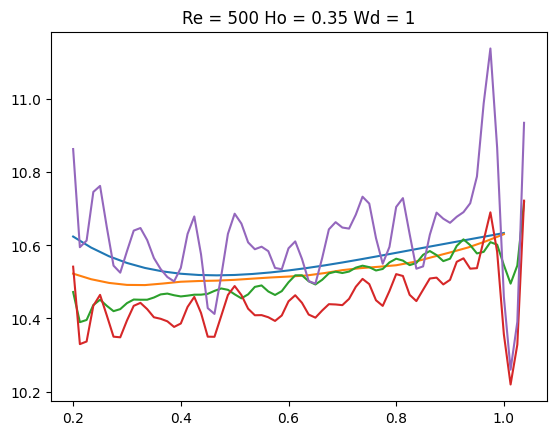

In [10]:
# Read Response Results

import csv
from os import listdir
import numpy as np
import matplotlib.pyplot as plt


# resultsFilePath="./resultsOpt.csv"

# dirSkip = ["dataOnly1800@500k", "pressureDataPlusPhysicsLambda1@500k", ""]

resultsPath = "./responseResults/"

# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@300k"]
# models = ["physicsOnly@500k", "data1800PlusPhysicsLambda01@500k"]
models = listdir(resultsPath)
models.sort()

# models = ["data1800PlusPhysicsLambda1@500k", "data1800PlusPhysicsLambda1FC@300k"]

for L in ["1", "0.1"]:
    for reNr in [500, 800]:
        for HoV in [0.35, 0.4, 0.45]:
        # for HoV in [0.2, 0.3, 0.4]:
            title = "Re = " + str(reNr) + " Ho = " + str(HoV) + " Wd = " + L
            plt.figure()
            plt.title(title)
            
            #plot ansys response for comparison
            ansysFilePath = "./AnsysResponseRe" + str(reNr) + "Ho" + str(HoV) + ".csv"
            with open(ansysFilePath, "r") as ansysFile:
                x_vals_ans = []
                y_vals_ans = []
                reader = csv.reader(ansysFile, delimiter=",")
                for i in range(8):
                        reader.__next__()
                for row in reader:
                    x_vals_ans.append(float(row[0]))
                    y_vals_ans.append(float(row[1]))
            
            plt.plot(x_vals_ans, y_vals_ans, label="ansys disc")
            
            ansysFilePath = "./AnsysResponse100Re" + str(reNr) + "Ho" + str(HoV) + ".csv"
            with open(ansysFilePath, "r") as ansysFile:
                x_vals_ans = []
                y_vals_ans = []
                reader = csv.reader(ansysFile, delimiter=",")
                for i in range(8):
                        reader.__next__()
                for row in reader:
                    x_vals_ans.append(float(row[0]))
                    y_vals_ans.append(float(row[1]))
            
            plt.plot(x_vals_ans, y_vals_ans, label="ansys cont")

            #plot response for modulus models
            for model in models:
                if model in dirSkip or ("Lambda" + L.replace(".", "") not in model and "data" in model):
                    print("skipping ", model)
                    continue
                        
                path = resultsPath + model

                designs = np.load(path + "/designsRe" + str(reNr) + "Ho" + str(HoV) + ".npy")
                results = np.load(path + "/resultsRe" + str(reNr) + "Ho" + str(HoV) + ".npy")
                
                # designs = np.load(path + "/designsRe" + str(reNr) + "Lo" + str(HoV) + ".npy")
                # results = np.load(path + "/resultsRe" + str(reNr) + "Lo" + str(HoV) + ".npy")

                x_vals = [val[0] for val in designs]
                # x_vals = [val[1] for val in designs]
                
                modelStrSplit = model.split("@")
                
                if len(modelStrSplit) == 3:
                    label = shortNameDict[modelStrSplit[0]] + "@" + modelStrSplit[1].split("k")[0] + "k_" + shortNameDict[modelStrSplit[1].split("k")[-1]]
                elif len(modelStrSplit) == 2:
                    label = shortNameDict[modelStrSplit[0]]
                
                plt.plot(x_vals, results, label=label)
                
            plt.legend()
            plt.xlabel("Lo")
            plt.ylabel("delta Cp")
            plt.savefig(title + ".png", dpi = 600)

In [41]:
a = np.zeros(3, int)
a += np.array([4,5,6])
# c = a+b

In [42]:
a

array([4, 5, 6])